In [0]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge, MultiTaskElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression, CCA
from sklearn.ensemble import RandomForestRegressor 
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
import xgboost as xgb

np.random.seed(39)

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
# load lesion load matrix 
lesion_load_matrix = np.load('drive/My Drive/colab/lesions_load_matrix_absolute.npy')
print(lesion_load_matrix.shape)

# take log of lesion loads
lesion_load_df = pd.DataFrame(lesion_load_matrix)
lesion_load_log_df = np.log(1+lesion_load_df)

(1401, 144)


In [0]:
#patient_df.to_hdf('../data/patients.h5', key='p', mode='w')
patient_df = pd.read_hdf('drive/My Drive/colab/patients.h5', 'p')

In [0]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
np.random.seed(39)

SCORE_DOMAINS = ['Global Cognition', 'Language', 'Visuospatial Functioning', 'Memory',\
                 'Information Processing Speed', 'Executive Functioning']

def create_score_df(metric, score_type, fold, score):
    
    df = pd.DataFrame()
    df["Domains"] = SCORE_DOMAINS
    df["Metric"] = metric
    df["Score type"] = score_type
    df["Fold"] = fold
    df["Score"] = score

    return df

def perform_regression(X, y, estimator, my_grid, random_search_cv=False, nn=False):
    kfold_outer = KFold(n_splits=5)
    
    # R^2 
    train_rsq = []
    test_rsq = []
    
    # MAE
    train_mae = []
    test_mae = []
    
    # MSE
    train_mse = []
    test_mse = []
    
    scores_df = pd.DataFrame()
    
    i=1

    for train, test in kfold_outer.split(X):
        X_train = X[train]
        y_train = y[train]
        X_test = X[test]
        y_test = y[test]

        kfold_inner = KFold(n_splits=5)
        
        if random_search_cv:
            gs_est = RandomizedSearchCV(estimator=estimator, param_distributions=my_grid, n_jobs=4, \
                                        cv=kfold_inner, random_state=39, n_iter=20)
        else:
            gs_est = GridSearchCV(estimator=estimator, param_grid=my_grid, n_jobs=4, cv=kfold_inner)
        
        if nn==True:
            gs_est.fit(X_train, y_train, validation_data=(X_test, y_test))
        else: 
            gs_est.fit(X_train, y_train)

        y_predicted_train = gs_est.predict(X_train)
        y_predicted_test = gs_est.predict(X_test)
        
        train_rsq_k = r2_score(y_train, y_predicted_train, multioutput='raw_values')
        test_rsq_k = r2_score(y_test, y_predicted_test, multioutput='raw_values')        
        
        train_mae_k = mean_absolute_error(y_train, y_predicted_train, multioutput='raw_values')
        test_mae_k = mean_absolute_error(y_test, y_predicted_test, multioutput='raw_values')
        
        train_mse_k = mean_squared_error(y_train, y_predicted_train, multioutput='raw_values')
        test_mse_k = mean_squared_error(y_test, y_predicted_test, multioutput='raw_values')
        
        
        scores_df = pd.concat([scores_df, create_score_df("R2", "In-sample", i, train_rsq_k)], ignore_index=True)
        scores_df = pd.concat([scores_df, create_score_df("R2", "Out-of-sample", i, test_rsq_k)], ignore_index=True)
        
        scores_df = pd.concat([scores_df, create_score_df("MAE", "In-sample", i, train_mae_k)], ignore_index=True)
        scores_df = pd.concat([scores_df, create_score_df("MAE", "Out-of-sample", i, test_mae_k)], ignore_index=True)
        
        scores_df = pd.concat([scores_df, create_score_df("MSE", "In-sample", i, train_mse_k)], ignore_index=True)
        scores_df = pd.concat([scores_df, create_score_df("MSE", "Out-of-sample", i, test_mse_k)], ignore_index=True)
        
        print('\nFold-'+str(i) + ': Best params:', gs_est.best_params_)     
        i+=1
    
    return scores_df


def plot_scores(score_df, score_type, metric):
    
    plt.figure(figsize=(15, 10))

    data = score_df[(score_df["Score type"]==score_type) & (score_df["Metric"]==metric)]
    sns.barplot(x="Domains", y="Score", hue="Model", data=data, ci="sd", capsize=.2)
    plt.axhline(0, color="black")
    plt.ylim(-0.2,)
    plt.title(metric + " (" + score_type + ")", fontsize=30)

    plt.tight_layout()
    plt.show()

def plot_all_scores(score_df):
    plot_scores(score_df, "Out-of-sample", "R2")
    plot_scores(score_df, "Out-of-sample", "MAE")
    plot_scores(score_df, "Out-of-sample", "MSE")
    plot_scores(score_df, "In-sample", "R2")
    plot_scores(score_df, "In-sample", "MAE")
    plot_scores(score_df, "In-sample", "MSE")
    

## Regression Analysis

In [0]:
scaler_X = StandardScaler()
X = scaler_X.fit_transform(lesion_load_log_df)

In [0]:
scaler_Y = StandardScaler()
Y = scaler_Y.fit_transform(np.array(patient_df[patient_df.columns[5:11]]))

### Ridge

In [0]:
def perform_ridge(X, Y):
    print('Performing Ridge regression (5-fold nested CV) on each domain')
    estimator = MultiOutputRegressor(Ridge())
    #alpha = np.linspace(0, 10, 51)
    alpha = np.linspace(3000, 6000, 301)
    my_grid={"estimator__alpha": alpha}
    return perform_regression(X, Y, estimator, my_grid)

In [35]:
scores_ridge = perform_ridge(X, Y)

Performing Ridge regression (5-fold nested CV) on each domain

Fold-1: Best params: {'estimator__alpha': 4880.0}

Fold-2: Best params: {'estimator__alpha': 5730.0}

Fold-3: Best params: {'estimator__alpha': 5360.0}

Fold-4: Best params: {'estimator__alpha': 4590.0}

Fold-5: Best params: {'estimator__alpha': 5300.0}


### SVR

In [0]:
def perform_svr_rbf(X, Y):
    print('Performing SVR regression (5-fold nested CV) on each domain')
    estimator = MultiOutputRegressor(SVR(kernel='rbf'))
    my_grid={"estimator__C": [1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], "estimator__gamma": np.logspace(-4, 4, 9)}
    return perform_regression(X, Y, estimator, my_grid)

In [37]:
scores_svr = perform_svr_rbf(X, Y)

Performing SVR regression (5-fold nested CV) on each domain

Fold-1: Best params: {'estimator__C': 1.0, 'estimator__gamma': 0.1}

Fold-2: Best params: {'estimator__C': 1.0, 'estimator__gamma': 1.0}

Fold-3: Best params: {'estimator__C': 1.0, 'estimator__gamma': 1.0}

Fold-4: Best params: {'estimator__C': 1.0, 'estimator__gamma': 0.1}

Fold-5: Best params: {'estimator__C': 1.0, 'estimator__gamma': 1.0}


### Random Forest Regression

In [0]:
def perform_random_forest_regr(X, Y):
    print('Performing Random Forest regression (5-fold nested CV) on each domain')
    estimator = MultiOutputRegressor(RandomForestRegressor(random_state=39))

    n_estimators = [10, 100, 500, 1000, 1500]
    max_features = ['auto', 'sqrt', 'log2']
    max_depth = [10, 50, 100, None]
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    max_samples = [0.4, 0.5, 0.7, 0.8]
    
    my_grid = {'estimator__n_estimators': n_estimators,
               'estimator__max_features': max_features,
               'estimator__max_depth': max_depth,
               'estimator__min_samples_split': min_samples_split,
               'estimator__min_samples_leaf': min_samples_leaf,
               'estimator__max_samples': max_samples}
    
    return perform_regression(X, Y, estimator, my_grid, random_search_cv=True)

In [39]:
scores_rf = perform_random_forest_regr(X, Y)

Performing Random Forest regression (5-fold nested CV) on each domain


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



Fold-1: Best params: {'estimator__n_estimators': 100, 'estimator__min_samples_split': 5, 'estimator__min_samples_leaf': 4, 'estimator__max_samples': 0.7, 'estimator__max_features': 'log2', 'estimator__max_depth': 10}


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



Fold-2: Best params: {'estimator__n_estimators': 1000, 'estimator__min_samples_split': 5, 'estimator__min_samples_leaf': 4, 'estimator__max_samples': 0.8, 'estimator__max_features': 'log2', 'estimator__max_depth': 10}


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



Fold-3: Best params: {'estimator__n_estimators': 1000, 'estimator__min_samples_split': 5, 'estimator__min_samples_leaf': 4, 'estimator__max_samples': 0.8, 'estimator__max_features': 'log2', 'estimator__max_depth': 10}


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



Fold-4: Best params: {'estimator__n_estimators': 1000, 'estimator__min_samples_split': 5, 'estimator__min_samples_leaf': 4, 'estimator__max_samples': 0.8, 'estimator__max_features': 'log2', 'estimator__max_depth': 10}


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



Fold-5: Best params: {'estimator__n_estimators': 1000, 'estimator__min_samples_split': 5, 'estimator__min_samples_leaf': 4, 'estimator__max_samples': 0.8, 'estimator__max_features': 'log2', 'estimator__max_depth': 10}


### XGBoost

In [0]:
def perform_xgboost(X, Y):
  print('Performing XGBoost regression (5-fold nested CV) on each domain')
  estimator = MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror', random_state=39))
  my_grid = {'estimator__n_estimators'    : [10, 50, 100, 150, 200],
            "estimator__learning_rate"    : [0.10, 0.15, 0.20, 0.25] ,
            "estimator__max_depth"        : [ 3, 4, 5, 6, 8, 10],
            "estimator__min_child_weight" : [ 5, 7, 9, 11, 15 ],
            "estimator__gamma"            : [ 0.0, 0.1, 0.2 , 0.3],
            "estimator__booster"          : ['gbtree', 'gblinear',  'dart' ],
            "estimator__colsample_bytree" : [ 0.1, 0.2, 0.3, 0.4, 0.5 , 0.7, 1 ]}

  return perform_regression(X, Y, estimator, my_grid, random_search_cv=True)


In [41]:
scores_xgb = perform_xgboost(X, Y)

Performing XGBoost regression (5-fold nested CV) on each domain


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")



Fold-1: Best params: {'estimator__n_estimators': 10, 'estimator__min_child_weight': 11, 'estimator__max_depth': 3, 'estimator__learning_rate': 0.15, 'estimator__gamma': 0.3, 'estimator__colsample_bytree': 0.4, 'estimator__booster': 'gbtree'}


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")



Fold-2: Best params: {'estimator__n_estimators': 10, 'estimator__min_child_weight': 11, 'estimator__max_depth': 3, 'estimator__learning_rate': 0.15, 'estimator__gamma': 0.3, 'estimator__colsample_bytree': 0.4, 'estimator__booster': 'gbtree'}


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")



Fold-3: Best params: {'estimator__n_estimators': 10, 'estimator__min_child_weight': 11, 'estimator__max_depth': 3, 'estimator__learning_rate': 0.15, 'estimator__gamma': 0.3, 'estimator__colsample_bytree': 0.4, 'estimator__booster': 'gbtree'}


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")



Fold-4: Best params: {'estimator__n_estimators': 10, 'estimator__min_child_weight': 11, 'estimator__max_depth': 3, 'estimator__learning_rate': 0.15, 'estimator__gamma': 0.3, 'estimator__colsample_bytree': 0.4, 'estimator__booster': 'gbtree'}


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")



Fold-5: Best params: {'estimator__n_estimators': 10, 'estimator__min_child_weight': 11, 'estimator__max_depth': 3, 'estimator__learning_rate': 0.15, 'estimator__gamma': 0.3, 'estimator__colsample_bytree': 0.4, 'estimator__booster': 'gbtree'}


### Neural Net

In [0]:
# For fun
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense

def get_nn_model():
    model = Sequential()
    model.add(Dense(25, input_dim=X.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(10, kernel_initializer='normal', activation='relu'))
    model.add(Dense(5, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation=None))

    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def perform_nn_regr(X, Y):
    print('Performing Neural Network regression (5-fold nested CV)')
    estimator = MultiOutputRegressor(KerasRegressor(build_fn=get_nn_model, epochs=2, batch_size=4, verbose=0))
    return perform_regression(X, Y, estimator, {})

In [43]:
scores_nn = perform_nn_regr(X, Y)

Performing Neural Network regression (5-fold nested CV)


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



Fold-1: Best params: {}

Fold-2: Best params: {}

Fold-3: Best params: {}

Fold-4: Best params: {}

Fold-5: Best params: {}


In [0]:
# to plot results

scores_all_models = pd.DataFrame()

scores_ridge.insert(0, "Model", "Ridge")
scores_svr.insert(0, "Model", "SVR")
scores_rf.insert(0, "Model", "Random Forest")
scores_xgb.insert(0, "Model", "XGBoost")
scores_nn.insert(0, "Model", "Neural Network")

scores_all_models = pd.concat([scores_ridge, scores_svr, scores_rf, scores_xgb, scores_nn], ignore_index=True)

In [0]:
# persist results
scores_all_models.to_hdf('drive/My Drive/colab/results_atlas_single_output_regr.h5', key='p', mode='w')

In [0]:
#scores_all_models = pd.read_hdf('drive/My Drive/colab/results_atlas_single_output_regr.h5', 'p')

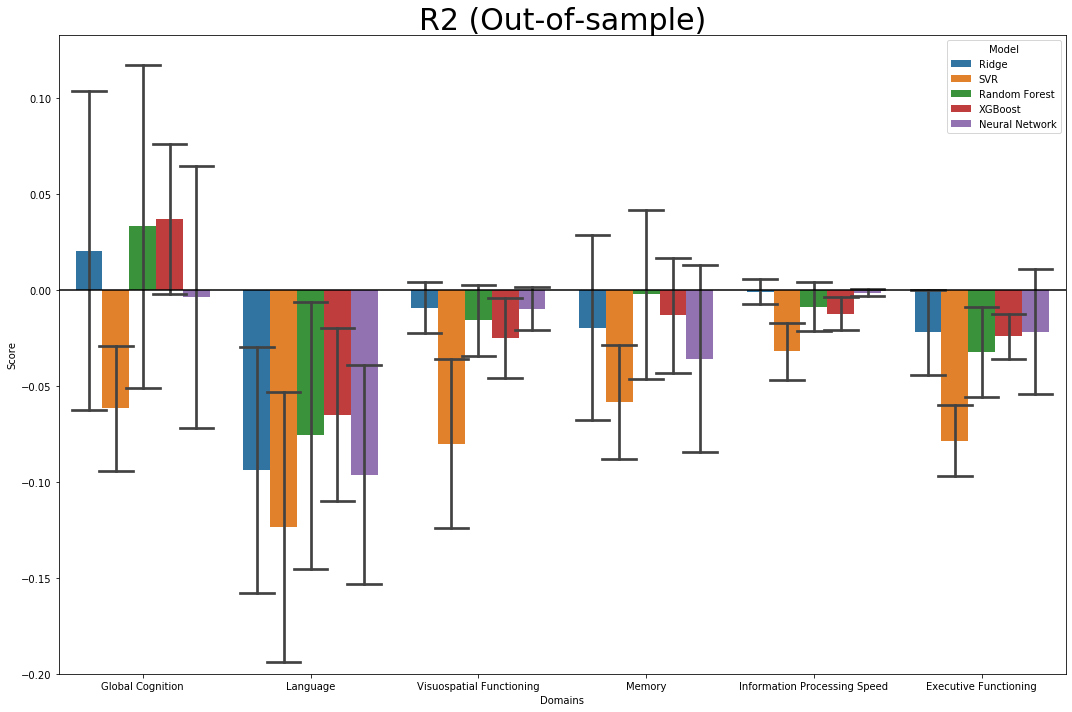

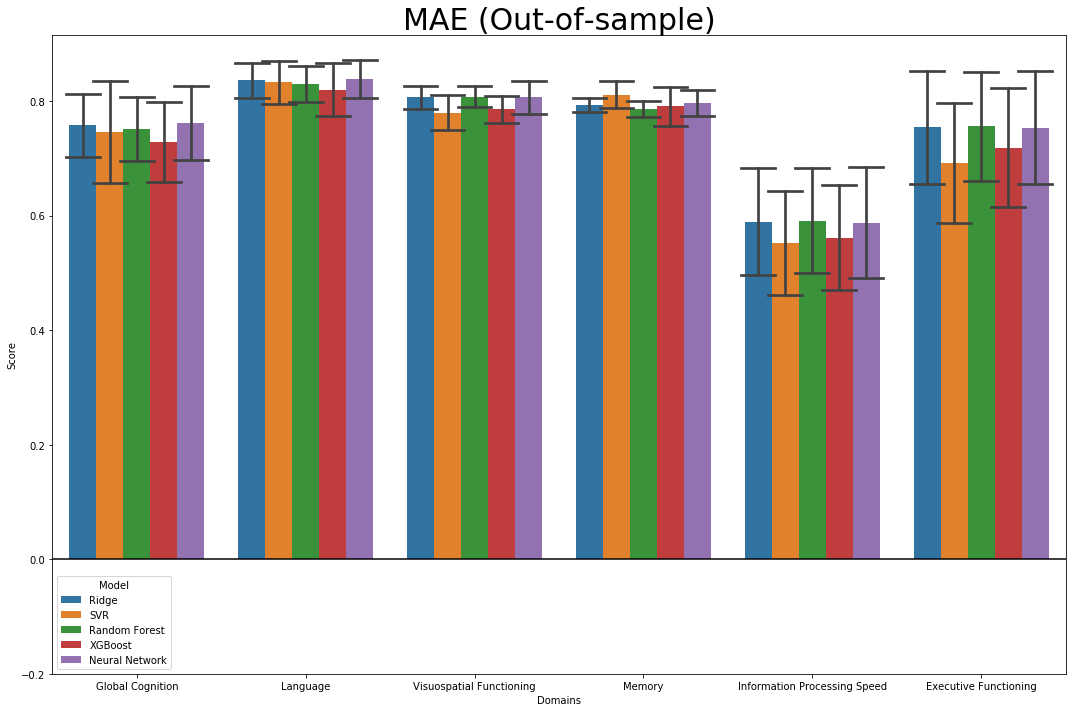

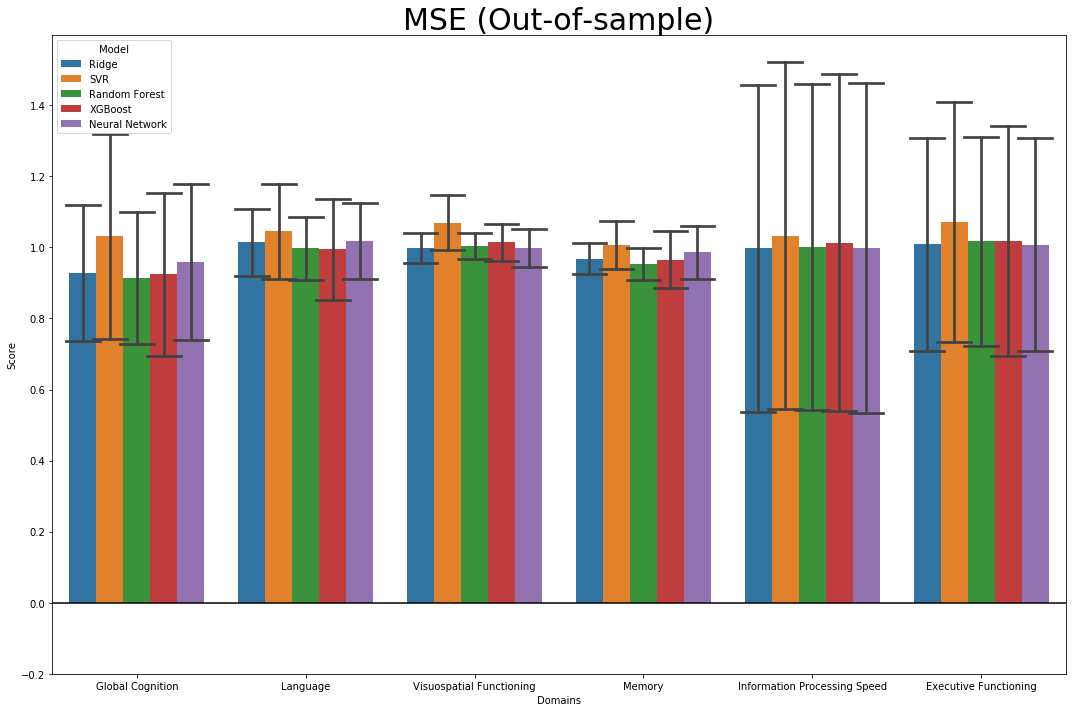

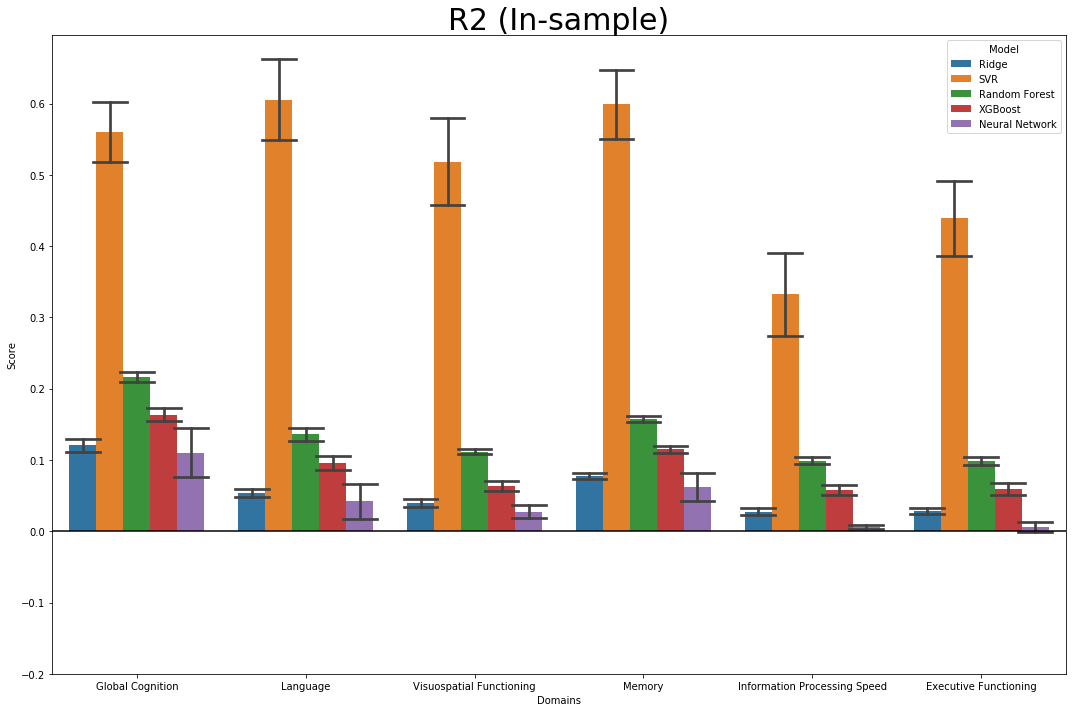

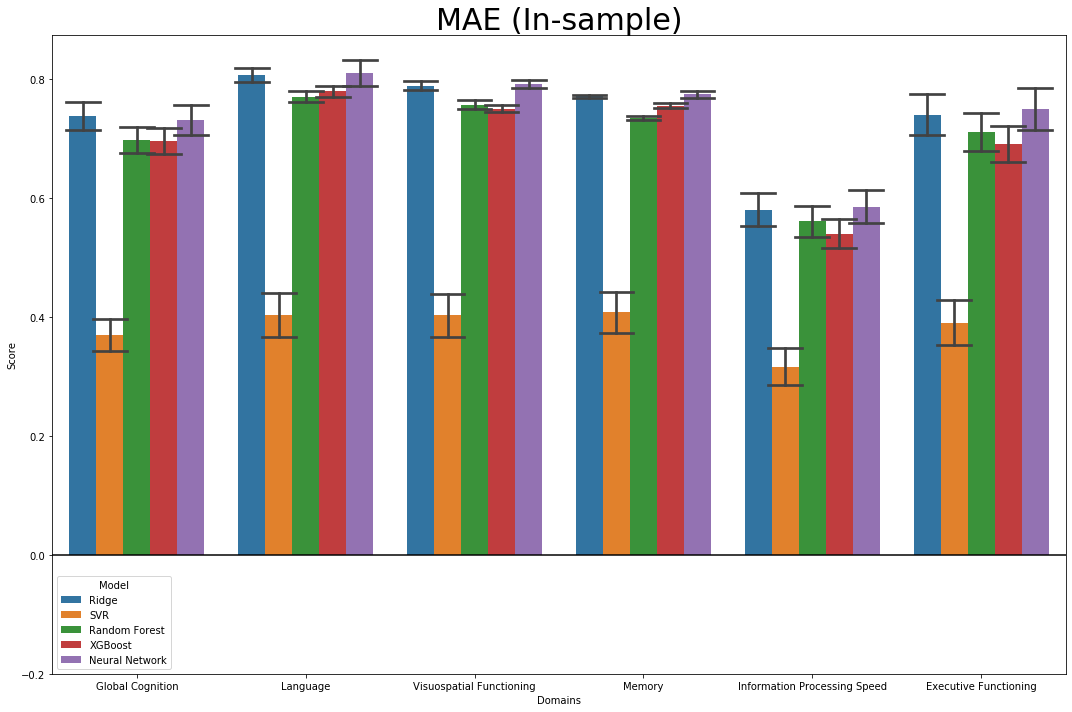

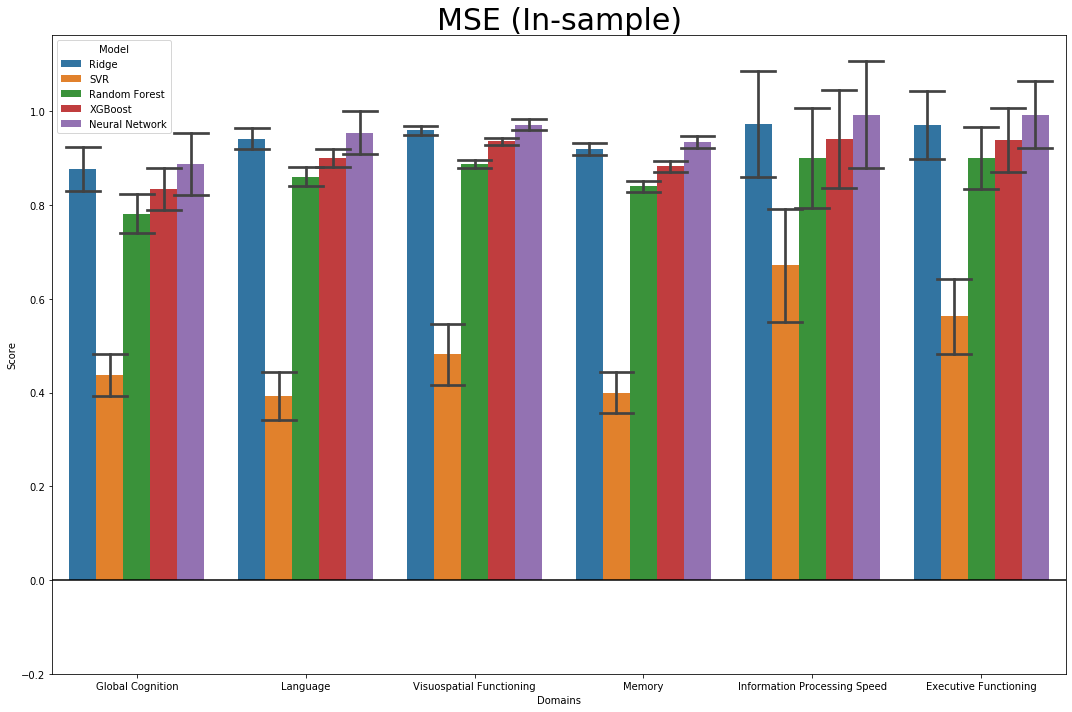

In [50]:
plot_all_scores(scores_all_models)

In [47]:
//Done

4